<a href="https://colab.research.google.com/github/shaunak-badani/Duke-Fall-24-Assignments/blob/main/520_Modeling_Processes_and_Algorithms/snippets/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
wget -q https://download.pytorch.org/tutorial/data.zip
unzip -qo data.zip

In [2]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Greek.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Korean.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Arabic.txt', 'data/names/Portuguese.txt', 'data/names/French.txt']
Slusarski


In [3]:
import numpy as np
import torch

In [4]:
all_letters_np = np.array(list(all_letters)).reshape(1, -1)

In [5]:
category_tensors = {}

for category in category_lines.keys():
    tensors = []
    for word in category_lines[category]:
      word_len = len(word)
      one_hot_vector = (np.array(list(word)).reshape(-1, 1) == np.tile(all_letters_np, (word_len, 1))).astype('uint8')
      one_hot_vector = np.expand_dims(one_hot_vector, axis = 1)
      tensors.append(torch.Tensor(one_hot_vector))
    category_tensors[category] = tensors

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class LetterRNN(nn.Module):

  def __init__(self, n_inp, n_hidden1, n_out):
    super().__init__()
    self.i2h = nn.Linear(n_inp, n_hidden1)
    self.h2h = nn.Linear(n_hidden1, n_hidden1)
    self.bn2 = nn.Linear(n_hidden1, n_out)
    self.logsoftmax = nn.LogSoftmax(dim = 1)
    self.n_hidden = n_hidden1
    self.hidden = self.initHidden()

  def forward(self, x):
    self.hidden = F.tanh(self.i2h(x) + self.h2h(self.hidden))
    x = self.logsoftmax(self.bn2(self.hidden))
    return x

  def initHidden(self):
    return torch.zeros((1, self.n_hidden))

In [7]:
rnn = LetterRNN(n_letters, 120, n_categories)
# hidden = rnn.initHidden()

In [8]:
dummy_input = category_tensors['French'][0][1]

outp = rnn(dummy_input)

In [9]:
outp

tensor([[-2.8836, -2.8927, -2.8316, -3.0124, -2.7797, -2.9883, -2.9213, -2.8781,
         -2.9981, -3.0782, -2.7964, -2.9787, -2.7345, -2.7890, -2.8105, -2.9141,
         -2.8322, -2.9862]], grad_fn=<LogSoftmaxBackward0>)

In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(outp))

('Russian', 12)


In [11]:
import random

def randomChoice(l):
    return random.randint(0, len(l) - 1)

In [12]:
def randomTrainingExample():
    category_idx = randomChoice(all_categories)
    category = all_categories[category_idx]
    c = randomChoice(category_tensors[category])
    category_tensor = category_tensors[category][c]
    return torch.Tensor([category_idx]).long(), category_tensor

for i in range(10):
    category_idx, category_tensor = randomTrainingExample()
    print('category =', all_categories[category_idx.item()], '/ tensor =', category_tensor.shape)

category = Greek / tensor = torch.Size([7, 1, 57])
category = Irish / tensor = torch.Size([8, 1, 57])
category = Scottish / tensor = torch.Size([6, 1, 57])
category = French / tensor = torch.Size([7, 1, 57])
category = Portuguese / tensor = torch.Size([6, 1, 57])
category = French / tensor = torch.Size([6, 1, 57])
category = Portuguese / tensor = torch.Size([9, 1, 57])
category = Russian / tensor = torch.Size([11, 1, 57])
category = Korean / tensor = torch.Size([3, 1, 57])
category = Italian / tensor = torch.Size([7, 1, 57])


In [13]:
rnn = LetterRNN(n_letters, 120, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.0005)
criterion = nn.NLLLoss()

def train_x(x, label):
  rnn.zero_grad()
  rnn.hidden = rnn.initHidden()

  n = x.shape[0]
  for i in range(n):
    outp = rnn(x[i])
  loss = criterion(outp, label)
  loss.backward()
  # optimizer.step()
  for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-0.005)
  return loss.item()
label, inp = randomTrainingExample()

In [14]:
n_iters = 100000
k = 5000

all_losses = []
losses = []
for epoch in range(n_iters):
  label, inp = randomTrainingExample()
  loss = train_x(inp, label)
  losses.append(loss)

  if epoch % k == 0:
    all_losses.append(np.mean(losses))
    losses = []

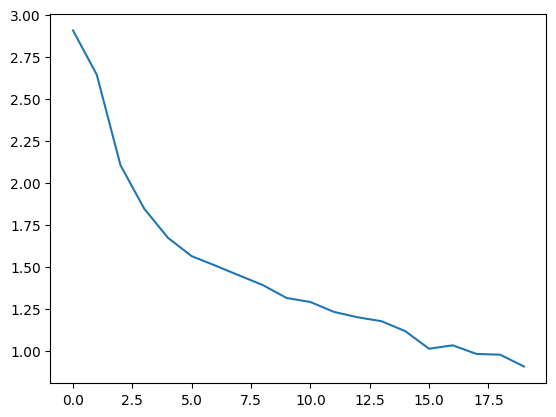

In [15]:
import matplotlib.pyplot as plt
plt.plot(all_losses)

### Checking NLLLoss with Cross Entropy Loss

- NLLoss expects inputs to be log probabilities
- So, it will just calculate -np.sum(a * b / n_classes)

- Cross Entropy Loss takes softmax probabilities as input, then takes the log and calculates probabilities

In [16]:
log_softmax = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()
# input to NLLLoss is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target must have 0 <= value < C
target = torch.tensor([1, 0, 4])
loss = loss_fn(log_softmax(input), target)

In [17]:
loss

tensor(1.8873, grad_fn=<NllLossBackward0>)

In [18]:
a = log_softmax(input)
b = F.one_hot(target)
manually_calculated_value = -torch.sum(a * b / 3)

assert np.isclose(manually_calculated_value.item(), loss.item())

In [19]:
!pip install torchviz

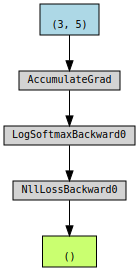

In [20]:
from torchviz import make_dot
make_dot(loss)

In [21]:
rnn.zero_grad()
rnn.hidden = rnn.initHidden()
label, x = randomTrainingExample()
print(x.shape)

n = x.shape[0]
for i in range(n):
  outp = rnn(x[i])
loss = criterion(outp, label)
current_loss = loss.item()
# current_loss = 0
# loss.backward()
# # optimizer.step()
# for p in rnn.parameters():
#       p.data.add_(p.grad.data, alpha=-0.005)
# return current_loss, loss.item()

torch.Size([10, 1, 57])


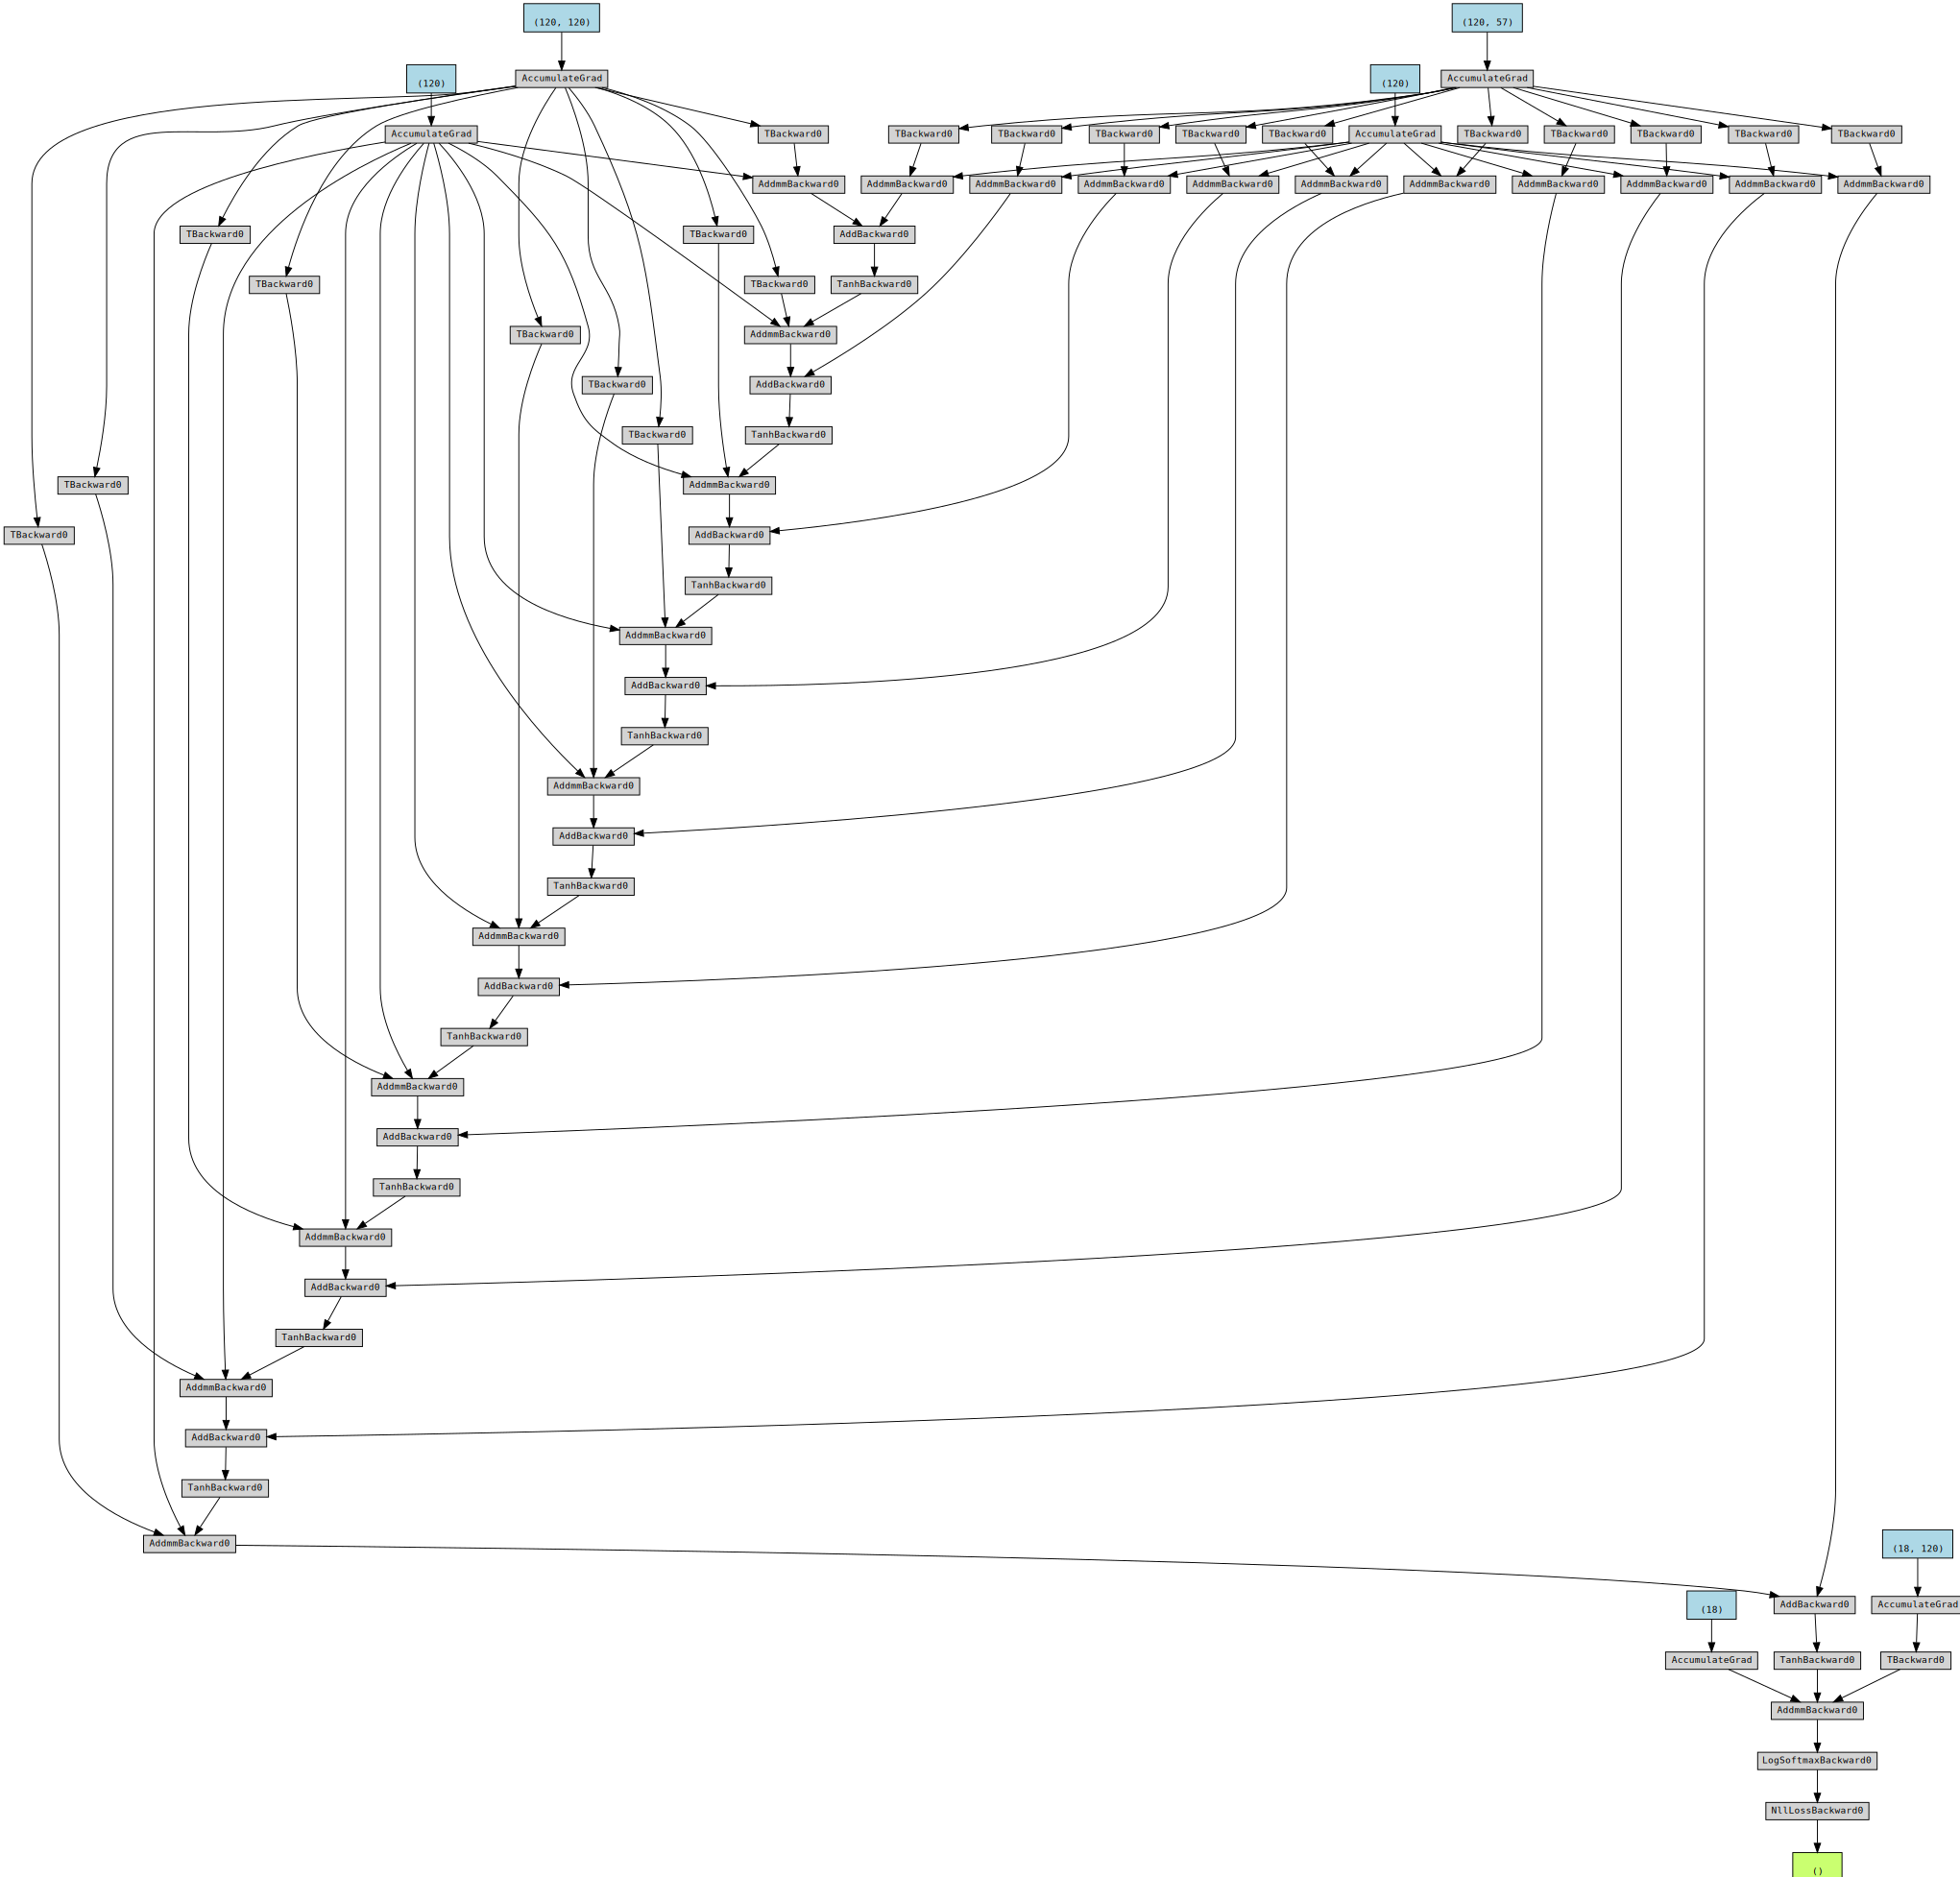

In [22]:
make_dot(loss)